# Trials for KFAC
## Generic setup (regression task)

In [1]:
using Pkg
Pkg.activate(".")
using LaplaceRedux
using LaplaceRedux.Curvature
using LaplaceRedux.Data
using Flux
using Flux.Optimise: update!, Adam
using Plots
using Statistics
using MLUtils
using Zygote
using Printf
using NNlib
using BenchmarkTools
using Tullio

  Activating new project at `~/Builds/navimakarov/LaplaceRedux.jl/dev/notebooks/KFAC`


In [2]:
# Init data
n = 2000
data_dict = Dict()
bsize = 10

x, y = LaplaceRedux.Data.toy_data_regression(n)
xs = [[x] for x in x]
X, Y = reduce(hcat, x), reduce(hcat, y)

# dataloader = DataLoader((X, Y), batchsize=bsize)
data = zip(xs, y)
data_dict[:regression] = Dict(
    :data => data,
    :X => X,
    :y => y,
    :outdim => 1,
    :loss_fun => :mse,
    :likelihood => :regression,
)

Dict{Symbol, Any} with 6 entries:
  :loss_fun   => :mse
  :y          => [-1.262, -1.1485, 0.481103, 0.50312, 0.127531, 0.926667, 0.548…
  :likelihood => :regression
  :X          => [5.92924 5.43385 … 2.16465 2.10173]
  :outdim     => 1
  :data       => zip([[5.92924], [5.43385], [0.0184016], [7.39229], [3.0214], […

In [6]:
# Train a NN model

val = data_dict[:regression]

# Unpack:
data = val[:data]
X = val[:X]
y = val[:y]
outdim = val[:outdim]
loss_fun = val[:loss_fun]
likelihood = val[:likelihood]

# Neural network:
n_hidden = 32
D = size(X, 1)
nn = Chain(Dense(D, n_hidden, σ), Dense(n_hidden, outdim))
λ = 0.01
sqnorm(x) = sum(abs2, x)
weight_regularization(λ=λ) = 1 / 2 * λ^2 * sum(sqnorm, Flux.params(nn))
loss(x, y) = getfield(Flux.Losses, loss_fun)(nn(x), y) + weight_regularization()


opt = Adam()
epochs = 200
avg_loss(data) = mean(map(d -> loss(d[1], d[2]), data))
show_every = epochs / 10

for epoch in 1:epochs
    for d in data
        gs = gradient(Flux.params(nn)) do
            l = loss(d...)
        end
        update!(opt, Flux.params(nn), gs)
    end
    if epoch % show_every == 0
        println("Epoch " * string(epoch))
        @show avg_loss(data)
    end
end

H_facs = nothing

Epoch 20
avg_loss(data) = 0.12874358820331147
Epoch 40
avg_loss(data) = 0.10347437301783545
Epoch 60
avg_loss(data) = 0.10231741089512186
Epoch 80
avg_loss(data) = 0.10168368867405946
Epoch 100
avg_loss(data) = 0.10121858614785856
Epoch 120
avg_loss(data) = 0.10084111537955492
Epoch 140
avg_loss(data) = 0.10052853379181098
Epoch 160
avg_loss(data) = 0.1002574346800815
Epoch 180
avg_loss(data) = 0.1000226570480998
Epoch 200
avg_loss(data) = 0.09982129551631228


## Exact Hessian of a Neural Network Loss

In [15]:
loss_fn(x, ytrue; agg=sum) = Flux.Losses.mse(nn(x), ytrue, agg=agg)

loss_fn (generic function with 1 method)

In [13]:
# Take one datapoint of the dataset
x_1 = xs[1]
y_1 = y[1]

-1.261995723816228

In [40]:
@benchmark Zygote.gradient(() -> Flux.Losses.mse($nn($x_1), $y_1), Flux.params($nn))

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  25.066 μs …   8.235 ms  ┊ GC (min … max): 0.00% … 98.01%
 Time  (median):     29.196 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   40.278 μs ± 138.012 μs  ┊ GC (mean ± σ):  5.79% ±  1.70%

  ▇▇▄█▅▁▂      ▁ ▁▂▃▃▂ ▂▄▄▂▁ ▂▃▃▂▁▁▁▂▂   ▁                     ▂
  ████████▇▅▅███████████████████████████████▇▇▆▆▆▆▆▅▅▅▅▅▅▅▅▄▄▅ █
  25.1 μs       Histogram: log(frequency) by time        94 μs <

 Memory estimate: 14.59 KiB, allocs estimate: 88.

In [39]:
@benchmark Zygote.gradient(nn -> Flux.Losses.mse(nn($x_1), $y_1), $nn)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  16.640 μs …   8.162 ms  ┊ GC (min … max): 0.00% … 98.21%
 Time  (median):     27.938 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   32.988 μs ± 114.243 μs  ┊ GC (mean ± σ):  4.79% ±  1.39%

  ▄▂█▆▁▁     ▁▂  ▂▁▁▅▅▄▃▂▂▃▄▄▃▂▁▁▁▁▂▂                          ▂
  ███████▆▇▆▄██▇███████████████████████▇▇▇▇▇▇▇▇▇▆▆▆▇▇▆▆▆▆▇▆▆▆▆ █
  16.6 μs       Histogram: log(frequency) by time        78 μs <

 Memory estimate: 10.56 KiB, allocs estimate: 56.

In [100]:
## H = Zygote.hessian(nn -> Flux.Losses.mse(nn(x_1), y_1), nn)
## H = ForwardDiff.hessian(nn -> Flux.Losses.mse(nn(x_1), y_1), nn)
# MethodError: no method matching hessian(::var"#47#48", ::Chain{Tuple{Dense{typeof(σ), Matrix{Float32}, Vector{Float32}}, Dense{typeof(identity), Matrix{Float32}, Vector{Float32}}}})
# H = Zygote.hessian(nn -> Flux.Losses.mse(nn(x_1), y_1), nn)

In [130]:
# https://fluxml.ai/Flux.jl/stable/destructure/
model = nn
theta, rebuild = Flux.destructure(model)

function lossv(theta::Vector)
    m = rebuild(theta)
    Flux.Losses.mse(m(x_1), y_1)
end;

H = Zygote.hessian(lossv, theta)

97×97 Matrix{Float64}:
 -4.31483      -1.78604      -2.34605      …  -0.0784301    -2.36349
 -1.78604      -2.33189       1.50021          0.050153      1.51136
 -2.34605       1.50021      -2.77862          0.0658784     1.98524
  0.156792     -0.100263     -0.1317          -0.00440283   -0.132679
  2.59541      -1.65967      -2.18005         -0.0728808    -2.19626
  2.24552      -1.43593      -1.88616      …  -0.0630556    -1.90018
  0.0984774    -0.0629725    -0.0827174       -0.0027653    -0.0833323
 -0.00111304    0.000711744   0.000934909      3.12547e-5    0.000941859
 -1.58687       1.01474       1.33291          0.0445603     1.34282
  0.0835587    -0.0534325    -0.0701862       -0.00234638   -0.0707079
  2.7635       -1.76715      -2.32124      …  -0.0776009    -2.3385
  0.144891     -0.092652     -0.121703        -0.00406862   -0.122608
 -2.37882       1.52117       1.99812          0.0667988     2.01298
  ⋮                                        ⋱   ⋮            
 -1.68555 

In [133]:
function norm_abs(H)
    H_abs = broadcast(abs, H)
    H_abs ./ findmax(H_abs)[1]
end

norm_abs (generic function with 1 method)

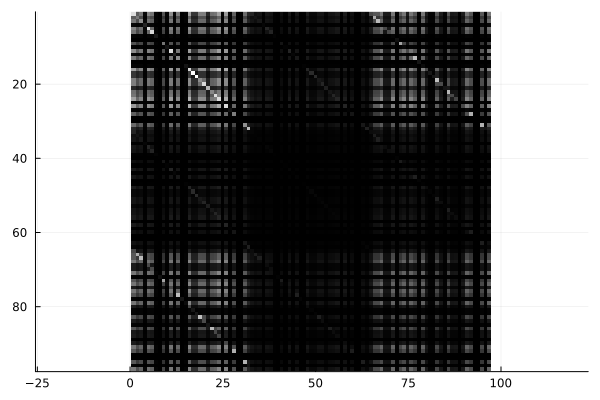

In [134]:
using Colors, Plots
plot(Gray.(norm_abs(H)))

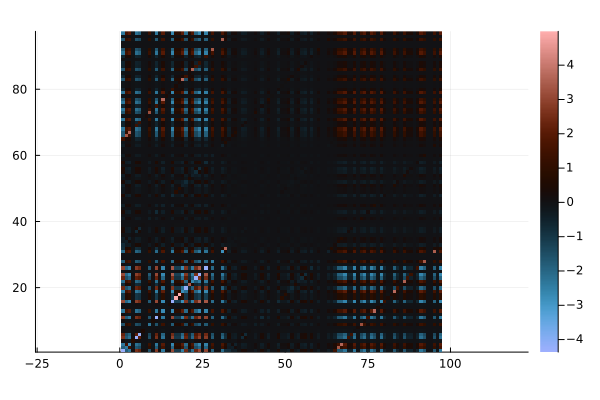

In [123]:
heatmap(H, color=:berlin, ratio=:equal)

In [114]:
?heatmap

search: heatmap heatmap! plots_heatmap plots_heatmap!



```
heatmap(x,y,z)
heatmap!(x,y,z)
```

Plot a heatmap of the rectangular array `z`.

# Keyword arguments

  * `aspect_ratio::Union{Real, Symbol}`: Plot area is resized so                  that 1 y-unit is the same size as                  `aspect_ratio` x-units. With `:none`, images inherit                  aspect ratio of the plot area. Use `:equal` for                  unit aspect ratio. Aliases: (:aspect*ratios,                  :aspectratio, :aspectratios, :axis*ratio, :axisratio,                  :ratio).

# Example

```julia-repl
julia> heatmap(randn(10,10))
```


In [108]:
ps = Flux.params(nn)
foreach(p -> println(size(p), " ", length(p)), ps)

(32, 1) 32
(32,) 32
(1, 32) 32
(1,) 1


In [94]:
# model = nnl
# lossfn = model -> Flux.Losses.mse(model(x_1), y_1)
# grad = model -> Zygote.gradient(model -> lossfn(model), model)
# jacob = model -> Zygote.jacobian(grad, model)
# jacob(model) ## does not work

In [93]:
## H = jacobian(() -> flat(gradient(() -> Flux.Losses.mse(nn(x_1), y_1), Flux.params(nn))), Flux.params(nn))
# Can't differentiate foreigncall expression $(Expr(:foreigncall, :(:jl_eqtable_get), Any, svec(Any, Any, Any), 0, :(:ccall), %5, %3, %4)).
# You might want to check the Zygote limitations documentation.
# https://fluxml.ai/Zygote.jl/latest/limitations

In [90]:
import Base: size
size(ps::Params) = (length(ps), )

size (generic function with 195 methods)

In [88]:
flat(grads::Zygote.Grads) = reduce(vcat, [vec(grads[t]) for t in grads.params])

flat (generic function with 1 method)

In [83]:
foreach(x -> println(size(x)), grads)

(32, 1)
(32,)
(1, 32)
(1,)


## Kron

In [2]:
mutable struct Kron1
#    kfacs :: Union{Vector{Tuple{AbstractArray, AbstractArray}},Vector{Matrix},Nothing}
    kfacs :: Vector{Tuple{AbstractArray, AbstractArray}}
end

Kron = Kron1
    
# mutable struct KronDecomposed
#     eigenvectors :: Union{AbstractArray,Nothing}
#     eigenvalues :: Union{AbstractArray,Nothing}
#     damping :: Bool
# end


Kron1

### Addition

In [17]:
import Base: +, ==, *

function (+)(l::Kron, r::Kron)
    @assert length(l.kfacs) == length(r.kfacs)
    kfacs = [Tuple(Hi + Hj for (Hi, Hj) in zip(Fi, Fj))
                for (Fi, Fj) in zip(l.kfacs, r.kfacs)]
    return Kron(kfacs)
end

function (==)(l::Kron, r::Kron)
    return l.kfacs == r.kfacs
end

# H = [[Fi + Fj for (Fi, Fj) in zip(Fi_row, Fj_row)] for (Fi_row, Fj_row) in zip(H.kfacs, H_batch.kfacs)]
#        kfacs = [[Hi.add(Hj) for Hi, Hj in zip(Fi, Fj)]
#                 for Fi, Fj in zip(self.kfacs, other.kfacs)]

== (generic function with 185 methods)

### Tests

In [9]:
using Test

In [10]:
left = Kron([([1 2], [3 4])])
right = Kron([([5 6], [7 8])])
total = left + right
@test total.kfacs == [([6 8], [10 12])]

Test Passed

In [16]:
left = Kron([([1 2], [3 4]), ([11 12], [13 14])])
right = Kron([([5 6], [7 8]), ([15 16], [17 18])])
total = left + right
@test total.kfacs == [([6 8], [10 12]), ([26 28], [30 32])]

Test Passed

In [13]:
left = Kron([])
total = left + left
@test total == left

Test Passed

In [15]:
left = Kron([([1 2], [3 4]), ([], [])])
right = Kron([([5 6], [7 8])])
@test_throws AssertionError left + right

Test Passed
      Thrown: AssertionError

In [8]:
collect(zip([1, 2, 3], [4, 5, 6, 7]))

3-element Vector{Tuple{Int64, Int64}}:
 (1, 4)
 (2, 5)
 (3, 6)

### Scaling

In [31]:
function (*)(l::Real, r::Kron)
        kfacs = [Tuple(^(l, 1/length(F)) * Hi for Hi in F) for F in r.kfacs]
        return Kron(kfacs)
end

(*)(l::Kron, r::Real) = (*)(r, l)

* (generic function with 311 methods)

### Tests

In [38]:
left = 4
right = Kron([([5 6], [7 8])])
@test left * right == right * left
@test (left * right).kfacs == [([10 12], [14 16])]

Test Passed

## Andrei's code

In [7]:
function init(model)
    kfacs = []

    for p in Flux.params(model)
        if ndims(p) == 1  # bias
            P = size(p, 1)
            push!(kfacs, [zeros(P, P)])
        elseif 4 >= ndims(p) >= 2  # fully connected or conv
            if ndims(p) == 2  # fully connected
                P_in, P_out = size(p)
            elseif ndims(p) > 2
                P_in, P_out = size(p, 1), prod(size(p)[2:end])
            end
            
            push!(kfacs, [
                zeros(P_in, P_in),
                zeros(P_out, P_out)
            ])
        else
            error("Invalid parameter shape in network.")
        end
    end
    # @show kfacs
    # @show get_array_sizes(kfacs)
    # @show print_arrays(kfacs)
    return Kron(kfacs)
end

init (generic function with 1 method)

In [8]:
function fitBeta(la::Laplace, data; batched::Bool=false, batchsize::Int, override::Bool=true)
    if override
        H = init(la.model)          
        loss = 0.0
        n_data = 0
    end

    # Training:
    for d in data
        x, y = d
        loss_batch, H_batch =_curv_closure(la.curvature, x, y, length(data))
        loss += loss_batch
        @show(H_batch)
        @show(H)
        H = [[Fi + Fj for (Fi, Fj) in zip(Fi_row, Fj_row)] for (Fi_row, Fj_row) in zip(H.kfacs, H_batch.kfacs)]
        n_data += batchsize
    end

    # Store output:
    la.loss = loss                                                           # Loss
    la.H = H                                                                 # Hessian
    la.P = posterior_precision(la)                                           # posterior precision
    la.Σ = posterior_covariance(la)                                          # posterior covariance
    return la.n_data = n_data                                                # number of observations
end

fitBeta (generic function with 1 method)

In [45]:
# fitting kron
function fitAux(la, train_loader, override=true, damping=false)
    if override
        H_facs = nothing
    end

    if !isnothing(H_facs)
        n_data_old = la.n_data
        n_data_new = length(train_loader)
        la.H = init(la.model) # re-init H non-decomposed
        # discount previous Kronecker factors to sum up properly together with new ones
        H_facs = _rescale_factors(H_facs, n_data_old / (n_data_old + n_data_new))
    end

    fitBeta(la, train_loader, batched=false, batchsize=1, override=override)

    if isnothing(H_facs)
        H_facs =la.H
    else
        # discount new factors that were computed assuming N = n_data_new
        la.H = _rescale_factors(la.H, n_data_new / (n_data_new + n_data_old))
        H_facs += la.H
    end
    # Decompose to self.H for all required quantities but keep H_facs for further inference
    la.H = decompose(la.H_facs, damping=damping)
end

fitAux (generic function with 3 methods)

In [46]:
function _curv_closure(curvature, x, y, N)
    return kron(curvature, x, y, N) #la.backend.kron(X, y, N=N)
end

_curv_closure (generic function with 1 method)

In [47]:
function posterior_precision(la::Laplace, H=la.H, P₀=la.P₀)
    @assert !isnothing(H) "Hessian not available. Either no value supplied or Laplace Approximation has not yet been estimated."
    return H .+ P₀
end

posterior_precision (generic function with 3 methods)

In [48]:
function posterior_covariance(la::Laplace, P=posterior_precision(la))
    @assert !isnothing(P) "Posterior precision not available. Either no value supplied or Laplace Approximation has not yet been estimated."
    return inv(P)
end

posterior_covariance (generic function with 2 methods)

In [49]:
function kron(curvature, x, y, N)
    #context = ifelse(self.stochastic, KFAC, KFLR)
    loss = curvature.factor * curvature.loss_fun(x, y)
    𝐠 = gradient(() -> curvature.loss_fun(x, y), Flux.params(curvature.model))
    𝐠 = reduce(vcat, [vec(𝐠[i]') for i in curvature.params])  
    # backpack(context()) do
    #     backward(loss)
    # end
    kron = Kron(𝐠)
    @show(kron)
    kron = _rescale_kron_factors(kron, length(y), N)
    return curvature.factor * loss, kron#curvature.factor * detach(loss), curvature.factor * kron
end

kron (generic function with 1 method)

In [50]:
function decompose(kron,damping=false)
    """
    Eigendecompose Kronecker factors and turn into `KronDecomposed`.
    
    Parameters
    ----------
    damping : bool
        use damping

    Returns
    -------
    kron_decomposed : KronDecomposed
    """
    eigvecs = []
    eigvals = []
    for F in kron.kfacs
        Qs = []
        ls = []
        for Hi in F
            l, Q = symeig(Hi)
            push!(Qs, Q)
            push!(ls, l)
        push!(eigvecs, Qs)
        push!(eigvals, ls)
        end
    end
    return KronDecomposed(eigvecs, eigvals, damping=damping)
end

decompose (generic function with 2 methods)

In [51]:
function _rescale_factors(kron, factor)
    for F in kron.kfacs
        if length(F) == 2
            F[1] *= factor
        end
    end
    return kron
end

_rescale_factors (generic function with 1 method)

In [52]:
function _rescale_kron_factors(kron, M, N)
    # Renormalize Kronecker factor to sum up correctly over N data points with batches of M
    # for M=N (full-batch) just M/N=1
    for F in kron.kfacs
        if length(F) == 2
            F[1] *= M/N
        end
    end
    return kron
end

_rescale_kron_factors (generic function with 1 method)

In [7]:
function _get_kron_factors(la)
    return Kron([p.kfac for p la.model.parameters])
end

LoadError: syntax: invalid iteration specification

In [54]:
# dataloader = DataLoader((X, Y), batchsize=10)

200-element DataLoader(::Tuple{Matrix{Float64}, Matrix{Float64}}, batchsize=10)
  with first element:
  (1×10 Matrix{Float64}, 1×10 Matrix{Float64},)

In [55]:
# function fit_la(nn, dataloader, X, y)
#     la_b = Laplace(nn; likelihood=:regression, λ=λ, subset_of_weights=:all)
#     fitAux(la_b, dataloader)
#     plot(la_b, X, y )
# end

fit_la (generic function with 1 method)

In [6]:
# fit_la(nn, dataloader, X, y)